# Project 2. Periodic Potentials in Quantum Mechanics
David Lapidus - s5860679

Ioan Leolea - s6039103

Karlis Driba - s6009611

Vainius Staškūnas - s5901154

## Abstract
Aim of the project is to look in details to behaviour of a system with a periodic potential in one dimension, e.g. mono-crystal structure as semiconductors, and a simple two-dimensional model for a trapped particle.

We will the natural units through this project.


In this project we will use time-independent Schrödinger equation: $$\frac{d^2\psi(x)}{dx^2} = -\frac{2m}{\hbar^2}(E-V(x))\psi(x).$$

## Libraries

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import warnings
from scipy.integrate import IntegrationWarning
import scipy.special as special
import scipy.integrate as integrate
from scipy.optimize import brentq
import math

## Constants

In [2]:
V0 = 50    # Potential depth V_0
a = 1          # Well width a
R0 = 1         # Well radius R_0

## 1. Periodic Potential

### Finite-depth Well Potential
$$V(x)=\begin{cases} V_0, & |x|>a/2, \\ 0,  & |x|\leq a/2 \end{cases},$$
where $V_0 = 50$ is a depth of the potential and $a = 1$ - width of the well in natural units.

#### Energies, wave functions and probability outside the well for bound states


number of bound states: 4

bound state energies and probabilities:
state    energy          P(|x|>a/2)     
----------------------------------------
n=0      3.413556        0.011606       
n=1      13.475652       0.050674       
n=2      29.452125       0.139177       
n=3      48.144890       0.488009       


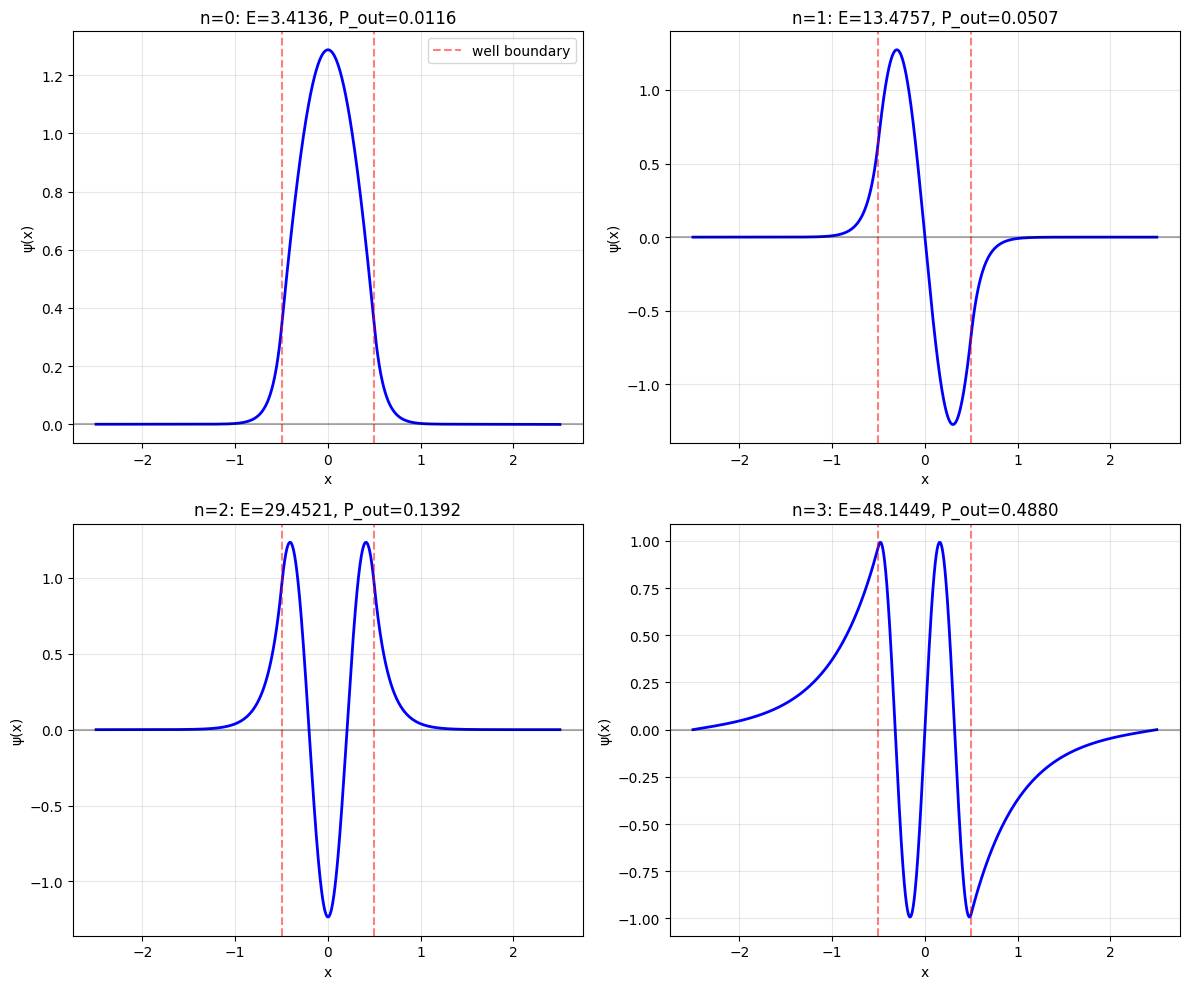

In [ ]:
def v(x):
    """"potential function"""
    return 0 if abs(x) < a/2 else V0

# shooting method
def integrate_schrodinger(E, xMax, dx):
    """evaluating approximation for the Schrödinger equation (book reference)"""
    x = -xMax + dx
    lastPsi = 0.0
    thisPsi = 0.001 * dx

    psi_list = [[x - dx, lastPsi], [x, thisPsi]]

    while x < xMax:
        nextPsi = 2 * thisPsi * (1 - dx**2 * (E - v(x))) - lastPsi
        x += dx
        psi_list.append([x, nextPsi])
        lastPsi = thisPsi
        thisPsi = nextPsi

    return np.array(psi_list)

def boundary_condition(E, xMax, dx):
    """getting values at boundary (should be around 0 for bound state)"""
    psi = integrate_schrodinger(E, xMax, dx)
    return psi[-1, 1]

def find_bound_states(E_min=0.1, E_max=49.9, xMax=2.5, dx=0.001, n_search=200):
    """finding all bound state energies"""
    # checking for sign changes and finding the energies where boundary condition changes sign

    energies_test = np.linspace(E_min, E_max, n_search)
    boundary_values = [boundary_condition(E, xMax, dx) for E in energies_test]

    bound_energies = []
    for i in range(len(boundary_values) - 1):
        if boundary_values[i] * boundary_values[i+1] < 0:
            # using brentq function to find the roots
            E_bound = brentq(boundary_condition, energies_test[i], energies_test[i+1],
                           args=(xMax, dx))
            bound_energies.append(E_bound)

    return bound_energies

def normalize_wavefunction(psi_array):
    """normalizing the wavefunction"""
    x = psi_array[:, 0]
    psi = psi_array[:, 1]
    # integrating using trapezoid function from numpy
    norm = np.sqrt(np.trapezoid(psi**2, x))
    psi_array[:, 1] = psi / norm
    return psi_array

def probability_outside_well(psi_array):
    """calculating probability of finding particle outside well"""
    x = psi_array[:, 0]
    psi = psi_array[:, 1]

    left_region = x < -a/2
    right_region = x > a/2

    prob_left = 0.0
    prob_right = 0.0

    if np.any(left_region):
        prob_left = np.trapezoid(psi[left_region]**2, x[left_region])

    if np.any(right_region):
        prob_right = np.trapezoid(psi[right_region]**2, x[right_region])

    return prob_left + prob_right

xMax = 2.5
dx = 0.001
bound_energies = find_bound_states(xMax=xMax, dx=dx) #? ask the ai for explanation

print(f"\nnumber of bound states: {len(bound_energies)}")
print(f"\nbound state energies and probabilities:")
print(f"{'state':<8} {'energy':<15} {'P(|x|>a/2)':<15}")
print("-" * 40)

# storing results
shooting_results = []

for i, E in enumerate(bound_energies):
    psi = integrate_schrodinger(E, xMax, dx)
    psi = normalize_wavefunction(psi)
    prob_out = probability_outside_well(psi)

    shooting_results.append({
        'n': i,
        'E': E,
        'psi': psi,
        'prob_out': prob_out
    })

    print(f"n={i:<6} {E:<15.6f} {prob_out:<15.6f}")

# plotting the wavefunctions
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, result in enumerate(shooting_results):
    ax = axes[i]
    x = result['psi'][:, 0]
    psi = result['psi'][:, 1]

    ax.plot(x, psi, 'b-', linewidth=2)
    ax.axvline(-a/2, color='r', linestyle='--', alpha=0.5, label='well boundary')
    ax.axvline(a/2, color='r', linestyle='--', alpha=0.5)
    ax.axhline(0, color='k', linestyle='-', alpha=0.3)
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('x')
    ax.set_ylabel('ψ(x)')
    ax.set_title(f'n={i}: E={result["E"]:.4f}, P_out={result["prob_out"]:.4f}')
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()

#### Estimation of precision of the results

In [ ]:
# estimating precision of the results
xMax_values = [2.0, 2.5, 3.0, 3.5]
dx_values = [0.002, 0.001, 0.0005]

print("\nvarying xMax (dx=0.001):")
print(f"{'xMax':<8} {'E_0':<15} {'E_3':<15} {'states':<10}")
print("-" * 50)
for xMax_test in xMax_values:
    energies = find_bound_states(xMax=xMax_test, dx=0.001)
    if len(energies) >= 4:
        print(f"{xMax_test:<8.1f} {energies[0]:<15.6f} {energies[3]:<15.6f} {len(energies):<10}")
    else:
        print(f"{xMax_test:<8.1f} {'N/A':<15} {'N/A':<15} {len(energies):<10}")

print("\nvarying dx (xMax=2.5):")
print(f"{'dx':<10} {'E_0':<15} {'E_3':<15}")
print("-" * 40)
for dx_test in dx_values:
    energies = find_bound_states(xMax=2.5, dx=dx_test)
    if len(energies) >= 4:
        print(f"{dx_test:<10.4f} {energies[0]:<15.6f} {energies[3]:<15.6f}")
    else:
        print(f"{dx_test:<10.4f} {'N/A':<15} {'N/A':<15}")


varying xMax (dx=0.001):
xMax     E_0             E_3             states    
--------------------------------------------------
2.0      3.413556        48.154659       4         
2.5      3.413556        48.144890       4         
3.0      3.413556        48.143490       4         
3.5      3.413556        48.143286       4         

varying dx (xMax=2.5):
dx         E_0             E_3            
----------------------------------------
0.0020     3.413510        48.144248      
0.0010     3.413556        48.144890      
0.0005     3.413567        48.145053      


The values vary very slightly with these increments showing that the results are accurate.

#### Energy levels and probabilities using the matrix method


basis size: 30, infinite well width: b=3.0
number of bound states: 4

bound state energies and probabilities:
state    energy          P(|x|>a/2)     
----------------------------------------
n=0      3.419884        0.011649       
n=1      13.499647       0.050873       
n=2      29.504769       0.139801       
n=3      48.283211       0.461522       


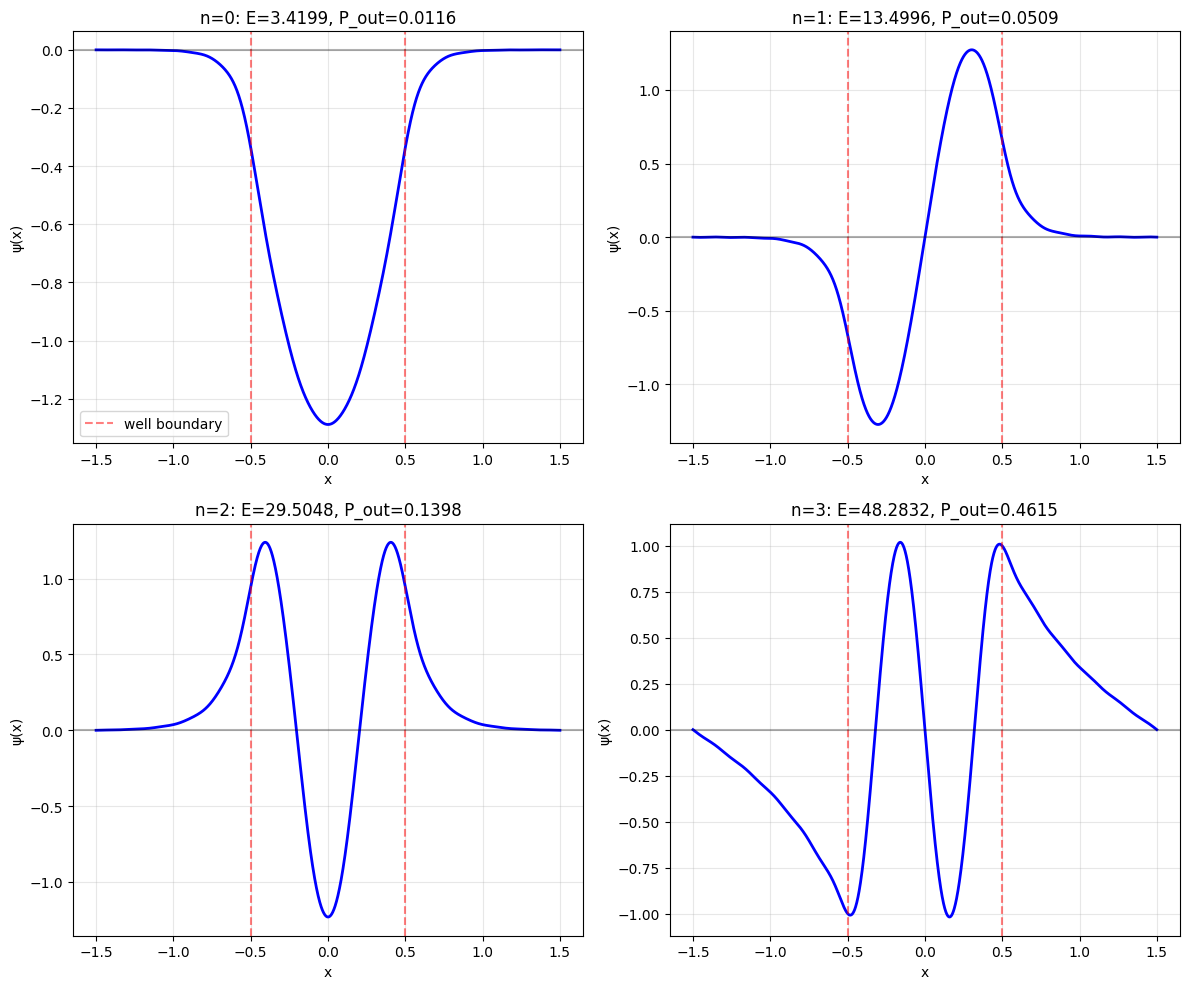

In [ ]:
#matrix method
def infinite_well_basis(n, x, b):
    """eigenfunction of infinite well"""
    return np.sqrt(2/b) * np.sin(n * np.pi * (x + b/2) / b)

def infinite_well_energy(n, b):
    """energy eigenvalue of infinite well"""
    return (n * np.pi / b)**2

def build_hamiltonian_matrix(N_basis, b):
    """building Hamiltonian matrix in infinite well basis"""
    #creating grid for integration
    x_grid = np.linspace(-b/2, b/2, 2000)
    dx_grid = x_grid[1] - x_grid[0]

    H = np.zeros((N_basis, N_basis))

    for i in range(N_basis):
        n_i = i + 1
        for j in range(N_basis):
            n_j = j + 1

            phi_i = infinite_well_basis(n_i, x_grid, b)
            phi_j = infinite_well_basis(n_j, x_grid, b)

            #kinetic energy: -1/2 * d²/dx² for infinite well basis: T = (n*pi/b)²/2
            if i == j:
                H[i, j] = 0.5 * infinite_well_energy(n_i, b)

            # V(x) (potential energy) for finite well (V0 outside, 0 inside)
            V_grid = np.where(np.abs(x_grid) > a/2, V0, 0)

            H[i, j] += np.trapezoid(phi_i * V_grid * phi_j, x_grid)

    return H

def solve_matrix_method(N_basis, b):
    """solving for eigenvalues and eigenvectors"""
    H = build_hamiltonian_matrix(N_basis, b)
    eigenvalues, eigenvectors = np.linalg.eigh(H)

    # filter for bound states (E < V0)
    bound_mask = eigenvalues < V0
    bound_energies = eigenvalues[bound_mask]
    bound_eigenvectors = eigenvectors[:, bound_mask]

    return bound_energies, bound_eigenvectors

def reconstruct_wavefunction(coeffs, b, x_eval):
    """reconstructing wavefunction from basis coefficients"""
    psi = np.zeros_like(x_eval)
    for i, c in enumerate(coeffs):
        n = i + 1
        psi += c * infinite_well_basis(n, x_eval, b)
    return psi

# solving with matrix method
N_basis = 30
b = 3.0  # width of infinite well (b > a)

matrix_energies, matrix_eigenvectors = solve_matrix_method(N_basis, b)

print(f"\nbasis size: {N_basis}, infinite well width: b={b}")
print(f"number of bound states: {len(matrix_energies)}")
print(f"\nbound state energies and probabilities:")
print(f"{'state':<8} {'energy':<15} {'P(|x|>a/2)':<15}")
print("-" * 40)
#evaluating wavefunctions
x_eval = np.linspace(-b/2, b/2, 2000)
matrix_results = []

for i in range(len(matrix_energies)):
    psi = reconstruct_wavefunction(matrix_eigenvectors[:, i], b, x_eval)

    norm = np.sqrt(np.trapezoid(psi**2, x_eval))
    psi = psi / norm

    left_region = x_eval < -a/2
    right_region = x_eval > a/2

    prob_left = 0.0
    prob_right = 0.0

    if np.any(left_region):
        prob_left = np.trapezoid(psi[left_region]**2, x_eval[left_region])

    if np.any(right_region):
        prob_right = np.trapezoid(psi[right_region]**2, x_eval[right_region])

    prob_out = prob_left + prob_right

    matrix_results.append({
        'n': i,
        'E': matrix_energies[i],
        'psi': psi,
        'x': x_eval,
        'prob_out': prob_out
    })

    print(f"n={i:<6} {matrix_energies[i]:<15.6f} {prob_out:<15.6f}")

# plotting wavefunctions from the matrix method
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i in range(min(4, len(matrix_results))):
    ax = axes[i]
    result = matrix_results[i]

    ax.plot(result['x'], result['psi'], 'b-', linewidth=2)
    ax.axvline(-a/2, color='r', linestyle='--', alpha=0.5, label='well boundary')
    ax.axvline(a/2, color='r', linestyle='--', alpha=0.5)
    ax.axhline(0, color='k', linestyle='-', alpha=0.3)
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('x')
    ax.set_ylabel('ψ(x)')
    ax.set_title(f'n={i}: E={result["E"]:.4f}, P_out={result["prob_out"]:.4f}')
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()

#### Estimation of precision of the results

In [ ]:
# estimating precision of results for the matrix method
N_basis_values = [15, 20, 30, 40]
b_values = [2.0, 2.5, 3.0, 4.0]

print("\nbasis size (b=3.0):")
print(f"{'N':<5} {'E_0':<12} {'E_1':<12} {'E_2':<12} {'E_3':<12} {'states':<8}")
print("-" * 65)
for N in N_basis_values:
    energies, _ = solve_matrix_method(N, 3.0)
    if len(energies) >= 4:
        print(f"{N:<5} {energies[0]:<12.6f} {energies[1]:<12.6f} {energies[2]:<12.6f} {energies[3]:<12.6f} {len(energies):<8}")
    elif len(energies) >= 1:
        E_str = " ".join([f"{energies[i]:<12.6f}" for i in range(len(energies))])
        print(f"{N:<5} {E_str} {'':<{12*(4-len(energies))}} {len(energies):<8}")

print("\ninfinite well width (N=30):")
print(f"{'b':<5} {'E_0':<12} {'E_1':<12} {'E_2':<12} {'E_3':<12} {'states':<8}")
print("-" * 65)
for b_test in b_values:
    energies, _ = solve_matrix_method(30, b_test)
    if len(energies) >= 4:
        print(f"{b_test:<5.1f} {energies[0]:<12.6f} {energies[1]:<12.6f} {energies[2]:<12.6f} {energies[3]:<12.6f} {len(energies):<8}")
    elif len(energies) >= 1:
        E_str = " ".join([f"{energies[i]:<12.6f}" for i in range(len(energies))])
        print(f"{b_test:<5.1f} {E_str} {'':<{12*(4-len(energies))}} {len(energies):<8}")


basis size (b=3.0):
N     E_0          E_1          E_2          E_3          states  
-----------------------------------------------------------------
15    3.441743     13.582984    29.716849    48.592086    4       
20    3.430554     13.524730    29.608670    48.363151    4       
30    3.419884     13.499647    29.504769    48.283211    4       
40    3.417935     13.492950    29.487328    48.267422    4       

infinite well width (N=30):
b     E_0          E_1          E_2          E_3          states  
-----------------------------------------------------------------
2.0   3.412053     13.470593    29.458304    48.899692    4       
2.5   3.412809     13.472077    29.448041    48.376471    4       
3.0   3.419884     13.499647    29.504769    48.283211    4       
4.0   3.418941     13.501266    29.500547    48.224311    4       


#### Comparison of shooting and matrix methods

In [ ]:
# comparing the two methods
print(f"\n{'state':<8} {'shooting E':<15} {'matrix E':<15} {'ΔE':<12} {'ΔP_out':<12}")
print("-" * 70)

for i in range(min(len(shooting_results), len(matrix_results))):
    E_shoot = shooting_results[i]['E']
    E_matrix = matrix_results[i]['E']
    P_shoot = shooting_results[i]['prob_out']
    P_matrix = matrix_results[i]['prob_out']

    print(f"n={i:<6} {E_shoot:<15.6f} {E_matrix:<15.6f} {abs(E_shoot-E_matrix):<12.6f} {abs(P_shoot-P_matrix):<12.6f}")


state    shooting E      matrix E        ΔE           ΔP_out      
----------------------------------------------------------------------
n=0      3.413556        3.419884        0.006328     0.000044    
n=1      13.475652       13.499647       0.023995     0.000199    
n=2      29.452125       29.504769       0.052643     0.000625    
n=3      48.144890       48.283211       0.138321     0.026488    


### Finite-depth Potential with Two Wells
$$V(x)=\begin{cases} V_0, & |x|>a+d/2, \\ V_0,  & |x|<d/2, \\ 0, & \text{elsewhere} \end{cases},$$
where $V_0 = 50$ is a depth of the potential, $a = 1$ and $d$ - width of each well and the distance between them in natural units.

#### Energies and wave functions for bound states

The goal is to solve the time-independent Schrödinger equation $$\hat{H}\psi=E\psi$$ for bound states ($E<V_0$) and find the unknown eigenenergies $E$ and eigenfunctions $\psi$. For this, we use the matrix method.

For the orthonormal basis we use the eigenfunctions of an infinite square well, centered at $x=0$: $$\phi_n=\sqrt{\frac{2}{b}}\sin\left(\frac{n\pi (x+b/2)}{b}\right),$$ so that we can write the eigenfunctions for our problem as a linear combination of basis functions: $$\psi=\sum_{n=1}^\infty c_n\phi_n(x)$$

We represent the Hamiltonian as an $n\times n$ matrix, where each entry is given by $$H_{mn}=E_n\delta_{mn}+\int_{-b/2}^{b/2}\phi_m^*(x)V(x)\phi_n^*(x)dx, $$ where $E_n=\frac{n^2\pi^2}{2b^2}$ is an eigenenergy of an infinite square well.

We then diagonalize this matrix to find its eigenvalues, which are going to be the eigenenergies for our problem, and the corresponding eigenvectors, which are going to form the eigenfunctions for our problem.

d = 0.0
P         E_1         E_2         E_3         E_4         E_5         E_6         E_7         
---------------------------------------------------------------------------------------
P_left    0.250000    0.250000    0.250000    0.250000    0.250000    0.250000    0.250000    
P_right   0.250000    0.250000    0.250000    0.250000    0.250000    0.250000    0.250000    

d = 0.1
P         E_1         E_2         E_3         E_4         E_5         E_6         E_7         
---------------------------------------------------------------------------------------
P_left    0.250000    0.250000    0.250000    0.250000    0.250000    0.250000    0.249997    
P_right   0.250000    0.250000    0.250000    0.250000    0.250000    0.250000    0.249997    

d = 0.2
P         E_1         E_2         E_3         E_4         E_5         E_6         E_7         
---------------------------------------------------------------------------------------
P_left    0.250000    0.250000    0.250000   

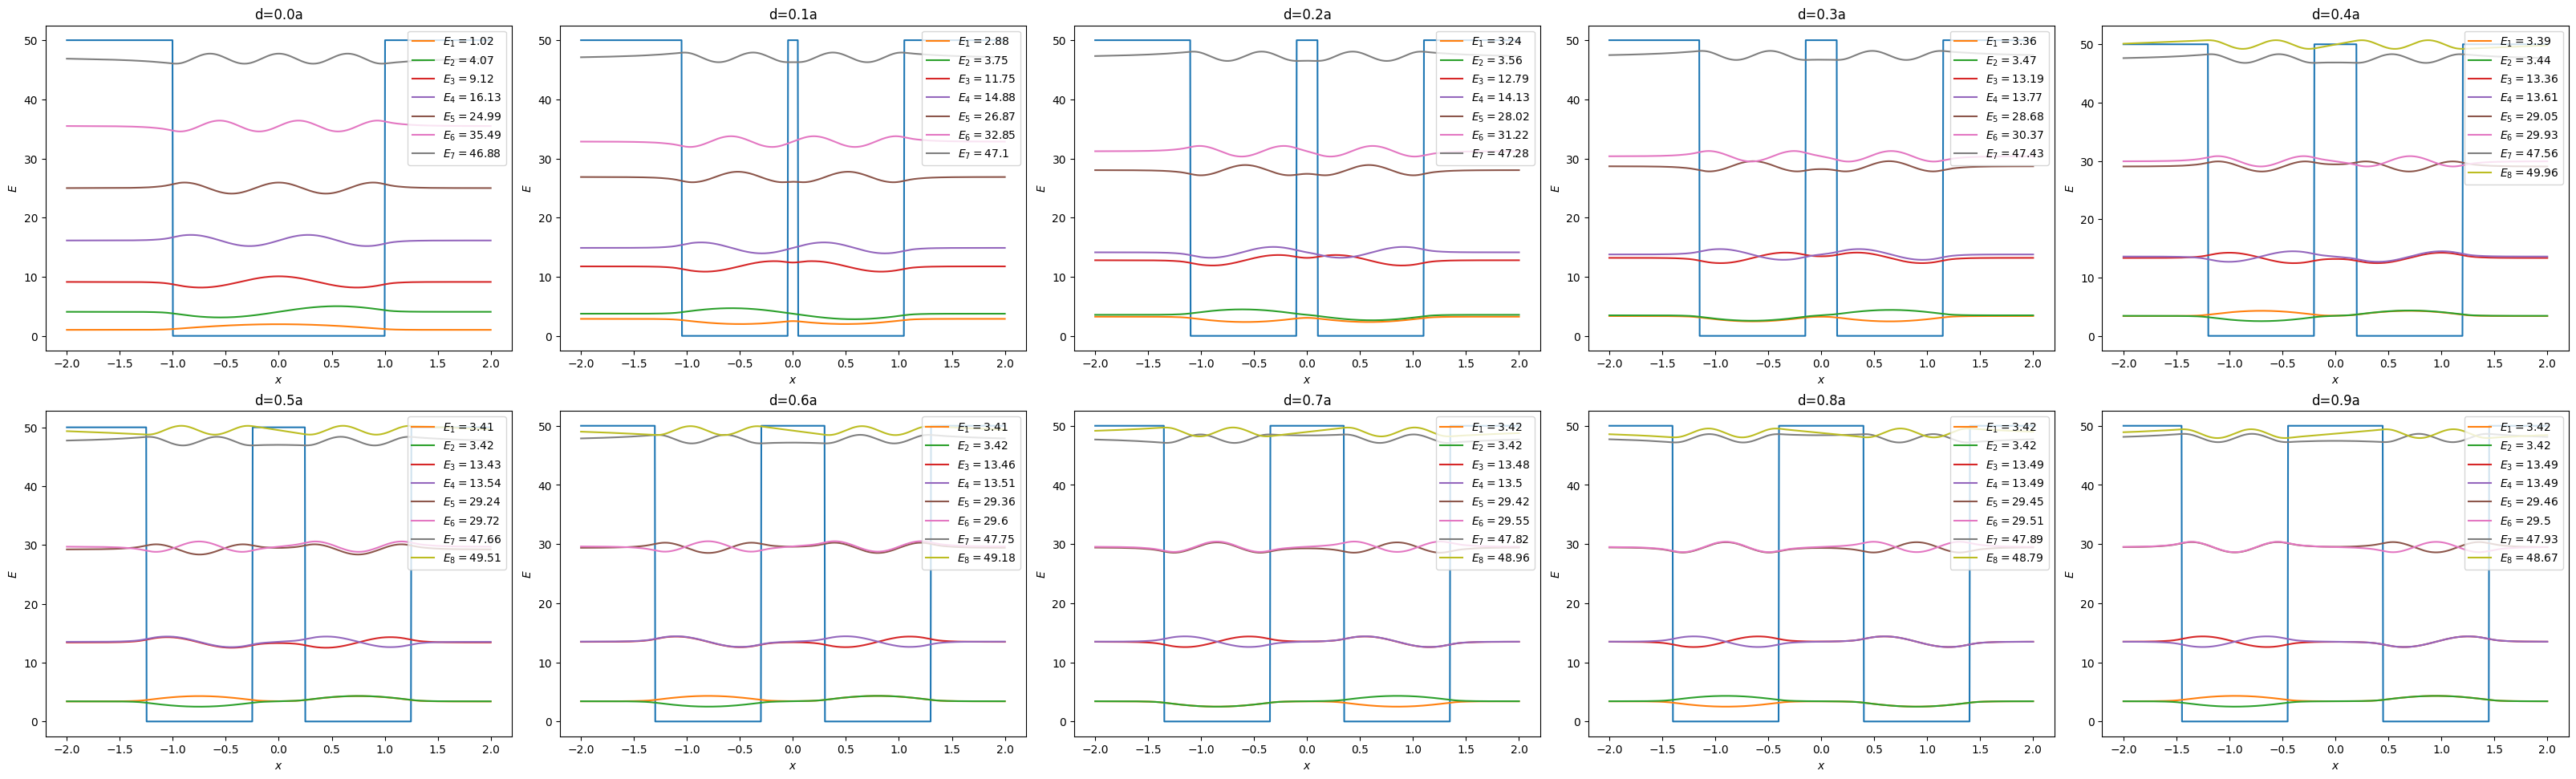

In [ ]:
def double_well_potential(x, a, d, V0):
    return np.where((np.abs(x) > a + d / 2) | (np.abs(x) < d / 2), V0, 0)

def basis_function(b, n, x):
    return np.sqrt(2/b) * np.sin(n*np.pi*(x+b/2)/b)

def matrix_method_solver_double_well(a, d, V0, n_max=50):
    b = 4*a + d

    delta = lambda m, n: int(m == n)

    H0 = lambda m, n: 0.5*(n*np.pi/b)**2 * delta(m, n)
    V = lambda m, n: sp.integrate.quad(lambda x: basis_function(b, m, x) * double_well_potential(x, a, d, V0) * basis_function(b, n, x), -b / 2, b / 2)[0]
    H_mn = lambda m, n: H0(m, n) + V(m, n)

    H = np.zeros((n_max, n_max))

    for i in range(n_max):
        for j in range(n_max):
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", IntegrationWarning)
                H[i, j] = H_mn(i+1, j+1)

    H = np.array(H)

    eigenvalues, eigenvectors = np.linalg.eigh(H)
    eigenenergies = eigenvalues[eigenvalues < V0]
    wavefunctions = eigenvectors[:, eigenvalues < V0]

    return eigenenergies, wavefunctions

def plot_wave_functions_finite_double_well(a, V0, d=None):
    if d is None:
        d = [a * i / 10 for i in range(0, 10)]

    grid_rows = int((len(d) - 1) // 5) + 1
    grid_cols = 5
    figure, axis = plt.subplots(grid_rows, grid_cols, figsize=(6.4*grid_cols, 4.8*grid_rows), constrained_layout=True)
    x = np.linspace(-a * 2, a * 2, 1000)

    for g_x in range(grid_rows):
        for g_y in range(grid_cols):
            d_index = g_x * grid_cols + g_y
            d_i = d[d_index]

            axis[g_x, g_y].set_title(f'd={d_i}a')
            axis[g_x, g_y].set_xlabel('$x$')
            axis[g_x, g_y].set_ylabel('$E$')
            axis[g_x, g_y].plot(x, double_well_potential(x, a, d_i, V0))

            b = 4*a + d_i

            eigenenergies, wavefunctions = matrix_method_solver_double_well(a, d_i, V0)
            probabilities = []

            for i in range(len(eigenenergies)):
                psi = np.zeros_like(x)

                for n, c in enumerate(wavefunctions[:, i]):
                    psi += c * basis_function(b, n + 1, x)

                probability_left = np.trapezoid(psi*psi, np.linspace(-a-d_i/2, -d_i/2, 1000))
                probability_right = np.trapezoid(psi*psi, np.linspace(d_i/2, a+d_i/2, 1000))
                probabilities.append((probability_left, probability_right))

                eigenenergy = eigenenergies[i]
                axis[g_x, g_y].plot(x, eigenenergy + psi, label=f'$E_{i+1}={round(eigenenergy, 2)}$')
                axis[g_x, g_y].legend(loc='upper right')

            # Header: energy levels
            print(f'd = {d_i}')
            print(f'{"P":<10}', end='')
            for j in range(len(eigenenergies)):
                print(f'E_{j+1:<10}', end='')
            print()

            # Separator
            print('-' * (10 + 11 * len(eigenenergies)))

            # P_left row
            print(f'{'P_left':<{10}}', end='')
            for i in range(len(probabilities)):
                print(f'{probabilities[i][0]:<12.6f}', end='')
            print()

            # P_right row
            print(f'{'P_right':<{10}}', end='')
            for i in range(len(probabilities)):
                print(f'{probabilities[i][1]:<12.6f}', end='')
            print('\n')

    plt.show()

plot_wave_functions_finite_double_well(a, V0)


The graphs above illustrate the behaviour of a double-well potential for varying values of the distance between the two wells $d$, ranging from $0$ to $0.9a$ in increments of $0.1a$. For the case $d=0$, the double well effectively reduces to a single well of double width ($a=2$), and the corresponding eigenenergy spectrum coincides with that of a single finite well of width $2a$.

As the separation $d$ increases, the eigenenergies of the system show only minor variations. In particular, beyond $d=0.5a$, the energy levels become almost indistinguishable form one another, indicating that further increasing the distance between the wells has very little effect of the spectrum. Interestingly, for $d\geq0.4a$, an additional 8th bound-state energy appears.

Analysis of the corresponding wavefunctions shows that for all tested configurations the probability of finding the particle in the left well is equal to that in the right well. This indicates that there is no preferable well in which the particle tends to localize, and the system remains symmetric in terms of probability distribution.

Furthermore, the eigenenergies exhibit a tendency to cluster into four distinct groups or formation zones, where several energy levels are closely spaced, separated by larger gaps between the zones. Within each formation zone, the energy levels are nearly degenerate, and the probability distributions of symmetric and antisymmetric states are identical. With increasing $d$, these formation zones become more clearly defined and easily distinguishable.

Overall, these results demonstrate that while the separation between the wells can slightly modify the higher bound-state energies, the double-well system preserves it symmetry, and no single well is favoured in terms of particle localization.



#### Bound-state energies and eigenfunctions for a four-well rectangular potential energy function

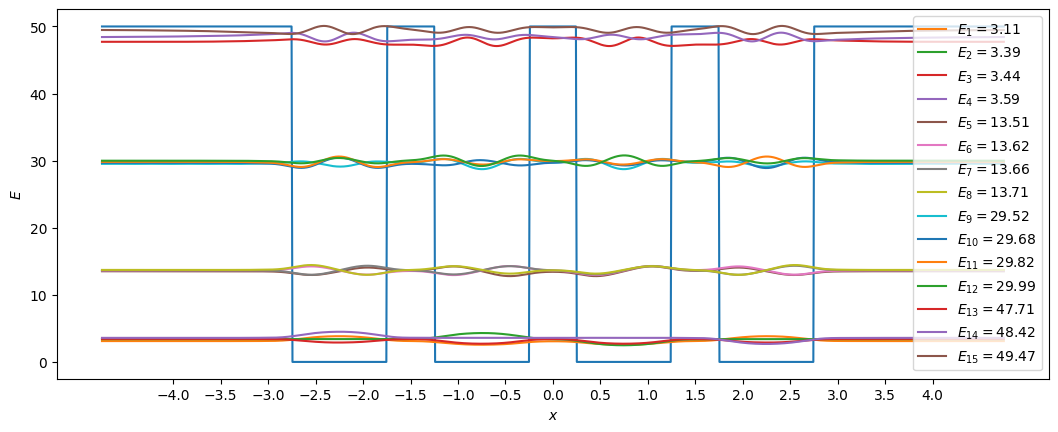

In [ ]:
def multi_well_potential(x, a, d, n, V0):
    """Generalized method for arbitrary number of wells"""

    p = a + d
    shift = p/2 * int(n % 2 == 1)

    l_half = (n*a + (n-1)*d) / 2.0
    y = (np.abs(x) + d/2.0 + shift) % p

    barrier_inside = y < d
    outside = np.abs(x) > l_half

    is_barrier = barrier_inside | outside
    return np.where(is_barrier, V0, 0)

def basis_function(b, n, x):
    return np.sqrt(2/b) * np.sin(n*np.pi*(x+b/2)/b)

def matrix_method_solver(a, d, N, V0, n_max=50):
    b = 2*N*a + (N-1)*d

    delta = lambda m, n: int(m == n)

    H0 = lambda m, n: 0.5*(n*np.pi/b)**2 * delta(m, n)
    V = lambda m, n: sp.integrate.quad(lambda x: basis_function(b, m, x) * multi_well_potential(x, a, d, N, V0) * basis_function(b, n, x), -b/2, b/2)[0]
    H_mn = lambda m, n: H0(m, n) + V(m, n)

    H = np.zeros((n_max, n_max))

    for i in range(n_max):
        for j in range(n_max):
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", IntegrationWarning)
                H[i, j] = H_mn(i+1, j+1)

    H = np.array(H)

    eigenvalues, eigenvectors = np.linalg.eigh(H)
    eigenenergies = eigenvalues[eigenvalues < V0]
    wavefunctions = eigenvectors[:, eigenvalues < V0]

    return eigenenergies, wavefunctions

def plot_multi_well_eigenfunctions(a, d, n, V0):
    eigenenergies, wavefunctions = matrix_method_solver(a, d, n, V0)
    b = 2*n*a + (n-1)*d

    figure, axis = plt.subplots(1, figsize=(6.4*2, 4.8))
    x = np.linspace(-b/2, b/2, 1000)
    axis.plot(x, multi_well_potential(x, a, d, n, V0))
    axis.set_xlabel('$x$')
    axis.set_ylabel('$E$')

    for i in range(len(eigenenergies)):
        psi = np.zeros_like(x)

        for j, c in enumerate(wavefunctions[:, i]):
            psi += c * basis_function(b, j + 1, x)

        eigenenergy = eigenenergies[i]
        axis.plot(x, eigenenergy + psi, label=f'$E_{{{i+1}}} = {round(eigenenergy, 2)}$')
        axis.legend(loc='upper right')
        axis.set_xticks(np.arange(-np.floor(b/2), np.floor(b/2)+0.5, 0.5))
    plt.show()

d = 0.5
plot_multi_well_eigenfunctions(a, d, 4, V0)

The matrix diagonalization method was applied to a four-well rectangular potential with each well having a width $a=1$, separated by barriers of width $d=0.5$ and height $V_0=50$ (in natural units).

As expected, the energy spectrum exhibits formation zones, with the 15 bound-state energies grouping into 4 distinct clusters. Each formation zone originates from the energy levels of an isolated single well. If the wells were infinitely far apart, each well would have the same set of discrete bound-state energies, and these would be exactly degenerate across the four wells.

Because the wells are at a finite distance apart, the wavefunctions in neighbouring wells overlap, allowing quantum tunneling between wells. This tunneling causes each originally degenerate energy level to split into several closely spaced levels, forming a cluster.

Within a formation zone, the energy levels are closely spaced, while the energy gaps between different zones remain larger, since the tunneling has a much smaller effect on the separation between higher and lower single-well levels.

The more well there are, the more levels appear in each formation zone. As the number of wells increases, the formation zones become more pronounced and easier to distinguish.

## 2. Two-dimensional Case
$$V(r, \phi)=\begin{cases} V_0r^2, & r<R_0, \\ V_0,  & r>R_0\end{cases},$$
where $V_0 = 50$ is the barrier height and $R_0 = 1$ is the radius of a well in natural units

In general the TISE can be written as $\nabla^2 \psi = - 2(E-V)\psi$, where we have set $\mu/\hbar^2=1$ ($\mu$ is the mass of the particle). In cylindrical coordinates $\nabla^2 = \frac{1}{r}\frac{\delta}{\delta r}\left( r \frac{\delta}{\delta r} \right) + \frac{1}{r^2}\frac{\delta^2}{\delta \phi^2} + \frac{\delta^2}{\delta z^2}$, where in our case the last term is not present since we assume the motion to be planr. This can be solved by separation of variables as $\psi(r,\phi) = R(r)Y(\phi)$. Simplifying one obtains that

$$\frac{r}{R}\frac{\delta}{\delta r}\left( r \frac{\delta R}{\delta r} \right) + 2(E-V)r^2 = \frac{1}{Y}\frac{\delta^2 Y}{\delta \phi^2}\,.$$

Each side of the equation must equate to a constant, say $(-m^2)$ (not to be confused with the mass $\mu$). Then

$$Y(\phi) = c_1 e^{im\phi} + c_2 e^{-im\phi}$$

applying the boundary condition $Y(0) = Y(2\pi)$ we obtain that $m \in \mathbb{Z}$ or since it only shows up squared we can restrict $m \in \mathbb{Z}_{\geq 0}$.

For the radial component we have

$$\frac{1}{r}\frac{\delta R}{\delta r}\left( r \frac{\delta R}{\delta r} \right) + \left[ 2(E-V) + \frac{m^2}{r^2} \right]R = 0\,.$$

This can be rewritten in the form $\hat{H}R = ER$, where

$$\hat{H} = -\frac{1}{2r}\frac{\delta}{\delta r}\left( r \frac{\delta}{\delta r} \right) + \left( V - \frac{m^2}{2r^2} \right)\,.$$

We choose to solve this method using the matrix method. We choose to form the basis using the eigenfunctions of the 2D harmonic oscillator in polar coordinates. For a given $n, m$ and $\alpha$ they are

$$\psi_n^m(q) = N_n^m \cdot q^m \cdot e^{-\frac{\alpha q^2}{2}} \cdot L_n^{(m)}(\alpha q^2)\, ,$$

where $L_n^{(m)}(\alpha q^2)$ is a generalized Laguerre polynomial (for $\alpha$ read further).


Since the equation also depends on the value of $m$ we set up different matrices $\hat{H}_m$ depending on the value of $m$. Then the full $\hat{H}$ matrix is block diagonal with matrices $\hat{H}_m$.

From our choice of basis we can split the Hamiltonian as

$\hat{H} = \hat{H}_0 + \Delta V$, where $\Delta V = 0$ if $r < 1$, and $\Delta V = V_0(1-r^2)$ if $r \geq 1$. Then we have

$$\hat{H}^m_{kn} = \int \psi^*_k \hat{H}^m_0 \psi_n dq + \int \psi^*_k \Delta V \psi_n dq\, .$$

Since our choses basis is orthogonal and the functions are eigenfunctions of $\hat{H}_0$ the first term will form a diagonal matrix, while the second one will not in general be diagonal.

The diagonal entries formed by the first term are energy eigenvalues for the generic harmonic oscillator in cylindrical coordinates. For the potential $V=\frac{1}{2}\mu \omega^2 r^2$, where $\mu$ is the mass of the particle, they are

$$ E = \hbar \omega (2n + m + 1)\,. $$

Since we want the potential inside to be zero, we have that $\frac{1}{2}\mu \omega^2 = V_0$. Using our natural units we get that $\alpha := \frac{\mu \omega}{\hbar} = \hbar \omega = \sqrt{2 V_0}$, which in our case is 10. Therefore these diagonal elements are given in multiples of 10.

We perform the integration up to $16R_0$ to minimize error. We have chosen the basis to consist of 16 eigenfunctions as that ensures that the computation for the lowest energy eigenvalues is of sufficient accuracy.

There is an attached figure showing the possible bound states of the wave function. Bound states near $E=50$ might not actually be bound as the basis of size 16 is only used. These energy eigenvalues might converge to a value above 50. The plots are organized to show the possible solutions for different sets of parameters $n,m$ corresponding to roughly the same energy eigenvalue. The 3D plots show the corresponding wavefunctions up to radius $1.5R_0$. The corresponding 2D plots show a radial slice of these plots. It can be seen that the wavefunction starts to decay exponentially in the region where $r>R_0$.

NB. This code is not optimized so the computation might run for several minutes (Google Colab does it in ~20min).

 ### Lowest energy-levels

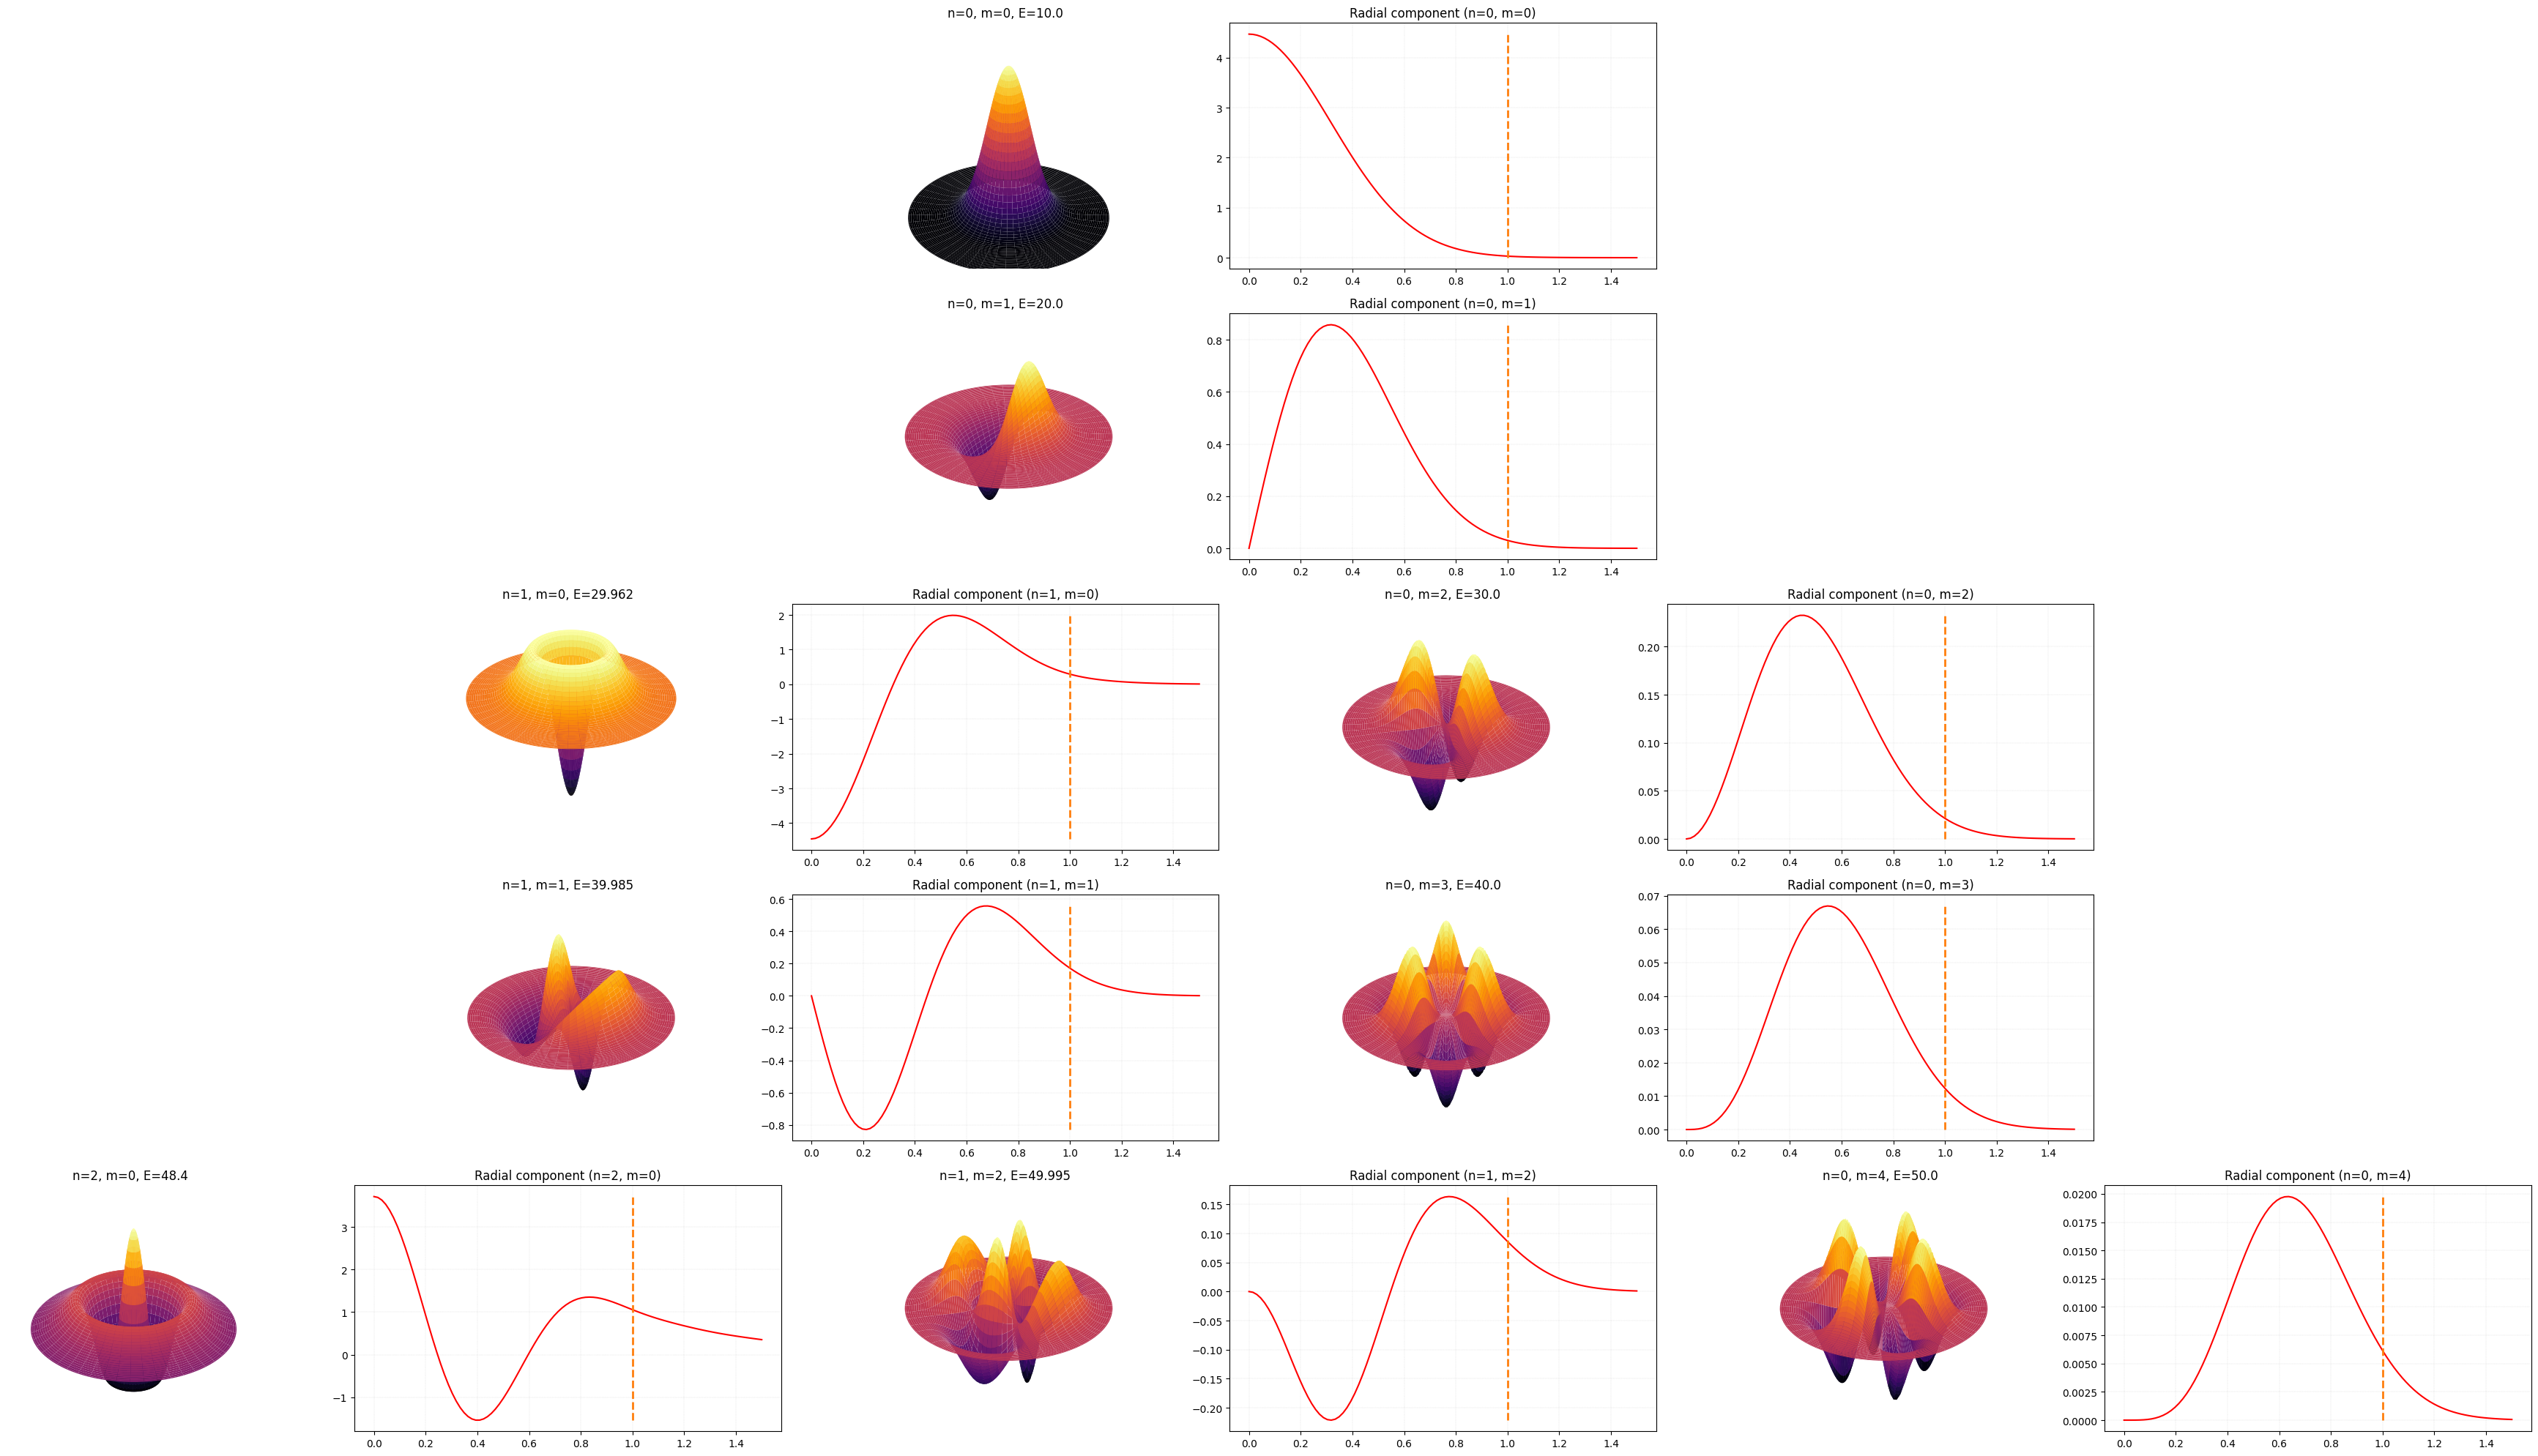

In [5]:
alpha = 10
size = 16 # basis cardinality

# The potential difference
def DV0(r):
    return 0 if r < 1 else V0 * (1 - r**2)

def IWantAPlot(m, eignum, justeig=False):
  """
  Computes the wavefunction corresponding to the
  energy eigenvalue eignum and angular constant m.

  Params:
  m (int) - nonnegative int (see text)
  eignum (int) - energy eigenvalue (nonegative int)
  justeig (bool) [optional] - output just energy eigenvalues

  Returns:
  X, Y (2D arrays) - 3D plot meshgrids for x-y plane
  Z_real (2D array) - the real part of the wavefunction at (x,y)
  eigvals[eignum] (float) - energy eigenvalue corresponding to this solution
  """
  Hm = np.zeros((size, size))

  # Normalized solutions to the generic harmonic oscillator
  def norm_lag(n, m, x):
    """Normalized radial sol at position x for the generic harmonic oscillator"""
    # Normalization constant
    Ni = np.sqrt(2 * alpha * math.factorial(n) / math.factorial(n + m))
    return Ni * np.power(x, m) * np.exp((-1) * alpha * x**2 / 2) *\
            special.genlaguerre(n, m)(alpha * x**2)

  # Constructing Hamiltonian
  for i in range(0, size):
    for j in range(0, size):
      # The second term in the Hamiltonian expansion
      Hm[i][j] = integrate.quad(
        lambda x: x * norm_lag(i, m, x) * DV0(x) * norm_lag(j, m, x),
        R0, 16 * R0)[0]
      # Diagonal eigenvalue part
      if i == j:
        Hm[i][j] += alpha * (2 * i + m + 1)

  # Eigenenergies and eigenvectors for the Hamiltonian
  eigvals, eigvecs = np.linalg.eigh(Hm)

  if justeig:
    print(eigvals)
    return 0

  def solution(eigvector, x):
    """Compute wavefunction solution for a given radial position x."""
    ans = np.zeros_like(x, dtype=float)
    for i in range(0, size):
      Ni = np.sqrt(2 * alpha * math.factorial(i) / math.factorial(i + m))
      ans += eigvector[i] * Ni * np.power(x, m) *\
              np.exp((-1) * alpha * x**2 / 2) *\
              special.genlaguerre(i, m)(alpha * x**2)
    return ans

  vfunc = np.vectorize(solution, excluded=['eigvector'])

  R = np.linspace(0, 1.5 * R0, 100)
  P = np.linspace(0, 2 * np.pi, 100)
  R, P = np.meshgrid(R, P)

  Z = vfunc(eigvector=eigvecs[:, eignum], x = R) * np.exp(1j * m * P)
  Z_real = np.real(Z)

  X, Y = R * np.cos(P), R * np.sin(P)

  return X, Y, Z_real, eigvals[eignum]

number = 3
max_m = 3

layout = [
  [(0, 0)],
  [(1, 0)],
  [(0, 1), (2, 0)],
  [(1, 1), (3, 0)],
  [(0, 2), (2, 1), (4, 0)]]

fig = plt.figure(figsize=(6 * 2 * 3, 4 * len(layout)))

total_cols = max(len(r) for r in layout) * 2
total_rows = len(layout)

for row_idx, row in enumerate(layout):
  # For centering subplots
  col_offset = (total_cols - 2 * len(row)) // 2

  for col_idx, (i, j) in enumerate(row):
    # Compute data
    X, Y, Z, eigvalue = IWantAPlot(i, j)

    # 3D wavefunction plot
    ax3d = fig.add_subplot(total_rows, total_cols,
                          row_idx * total_cols + col_offset + 2 * col_idx + 1,
                          projection='3d')
    ax3d.set_aspect('auto', adjustable='box')
    ax3d.set_box_aspect(None, zoom=1.5)
    ax3d.plot_surface(X, Y, Z, cmap='inferno')
    ax3d.set_title(f"n={j}, m={i}, E={round(eigvalue,3)}")
    ax3d.set_axis_off()


    # 2D radial slice plot
    ax2d = fig.add_subplot(total_rows, total_cols,
                          row_idx * total_cols +\
                          col_offset + 2 * col_idx + 2)
    ax2d.grid(True, color='gray', linestyle='--', linewidth=0.3, alpha=0.3)
    ax2d.set_aspect('auto', adjustable='box')
    ax2d.plot(X[0], Z[0], 'red')
    ax2d.vlines(x=1, ymin=min(Z[0]), ymax=max(Z[0]),
                colors=['tab:orange'], ls='--', lw=2, alpha=1)
    ax2d.set_title(f"Radial component (n={j}, m={i})")

plt.tight_layout()
# plt.savefig('figure_custom_layout.png', dpi=300)
plt.show()

The lowest energy eigenvalue is found to be ~10 in our natural units. The computational accuracy for the lower energy eigenvalues is good, but might be a bit off for larger values. Clearly eigenvalues in the angular component effect energy values and also radial solutions. This can also be seen in our equations as the two solutions interact through the constant $m$.

### Degenerate levels

The system has degenerate energy levels apart from the first one. This can be seen in the figure. There are multiple solutions with different $n, m$ values that correspond to roughly the same energy eigenvalues.